# Modeling Number of Kitas per PLZ in Berlin using a Hierarchical Bayesian Model

This notebook is the continuation of data gathering and data analysis post [Open Data: Berlin Kitas.](https://juanitorduz.github.io/kitas_berlin/). In this second part we use the data gathered to model the number of Kitas per PLZ in Berlin using a hierarchical bayesian model. The hierarchy is defined by the Berlin districts. The objective is to develop a sound basic model which can be enhanced in the future with a richer data set.

## Prepare Notebook

In [1]:
import arviz as az
import geopandas as gpd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.preprocessing import LabelEncoder

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=0)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

Let's start by reading the data we gathered in the previous post.


In [2]:
data_path = "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data//kitas_data.geojson"

plz_df: gpd.GeoDataFrame = gpd.read_file(data_path)

plz_df = plz_df.sort_values(by=["district", "plz"])

plz_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 214 entries, 46 to 213
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   plz                   214 non-null    object  
 1   einwohner             214 non-null    int64   
 2   district              214 non-null    object  
 3   num_kitas_plz         214 non-null    int64   
 4   spots_plz             214 non-null    float64 
 5   num_kitas_plz_pc      214 non-null    float64 
 6   num_kitas_plz_pc_log  214 non-null    float64 
 7   geometry              214 non-null    geometry
dtypes: float64(3), geometry(1), int64(2), object(2)
memory usage: 15.0+ KB


Recall that the features of interest are:
- `plz`: Postal code
- `einwohner`: Number of inhabitants
- `district`: Berlin district (there are 12 districts in Berlin)
- `num_kitas_plz`: Number of Kitas per postal code

We start by looking into the relationship between the number of inhabitants and the number of Kitas per postal code when grouping by district.

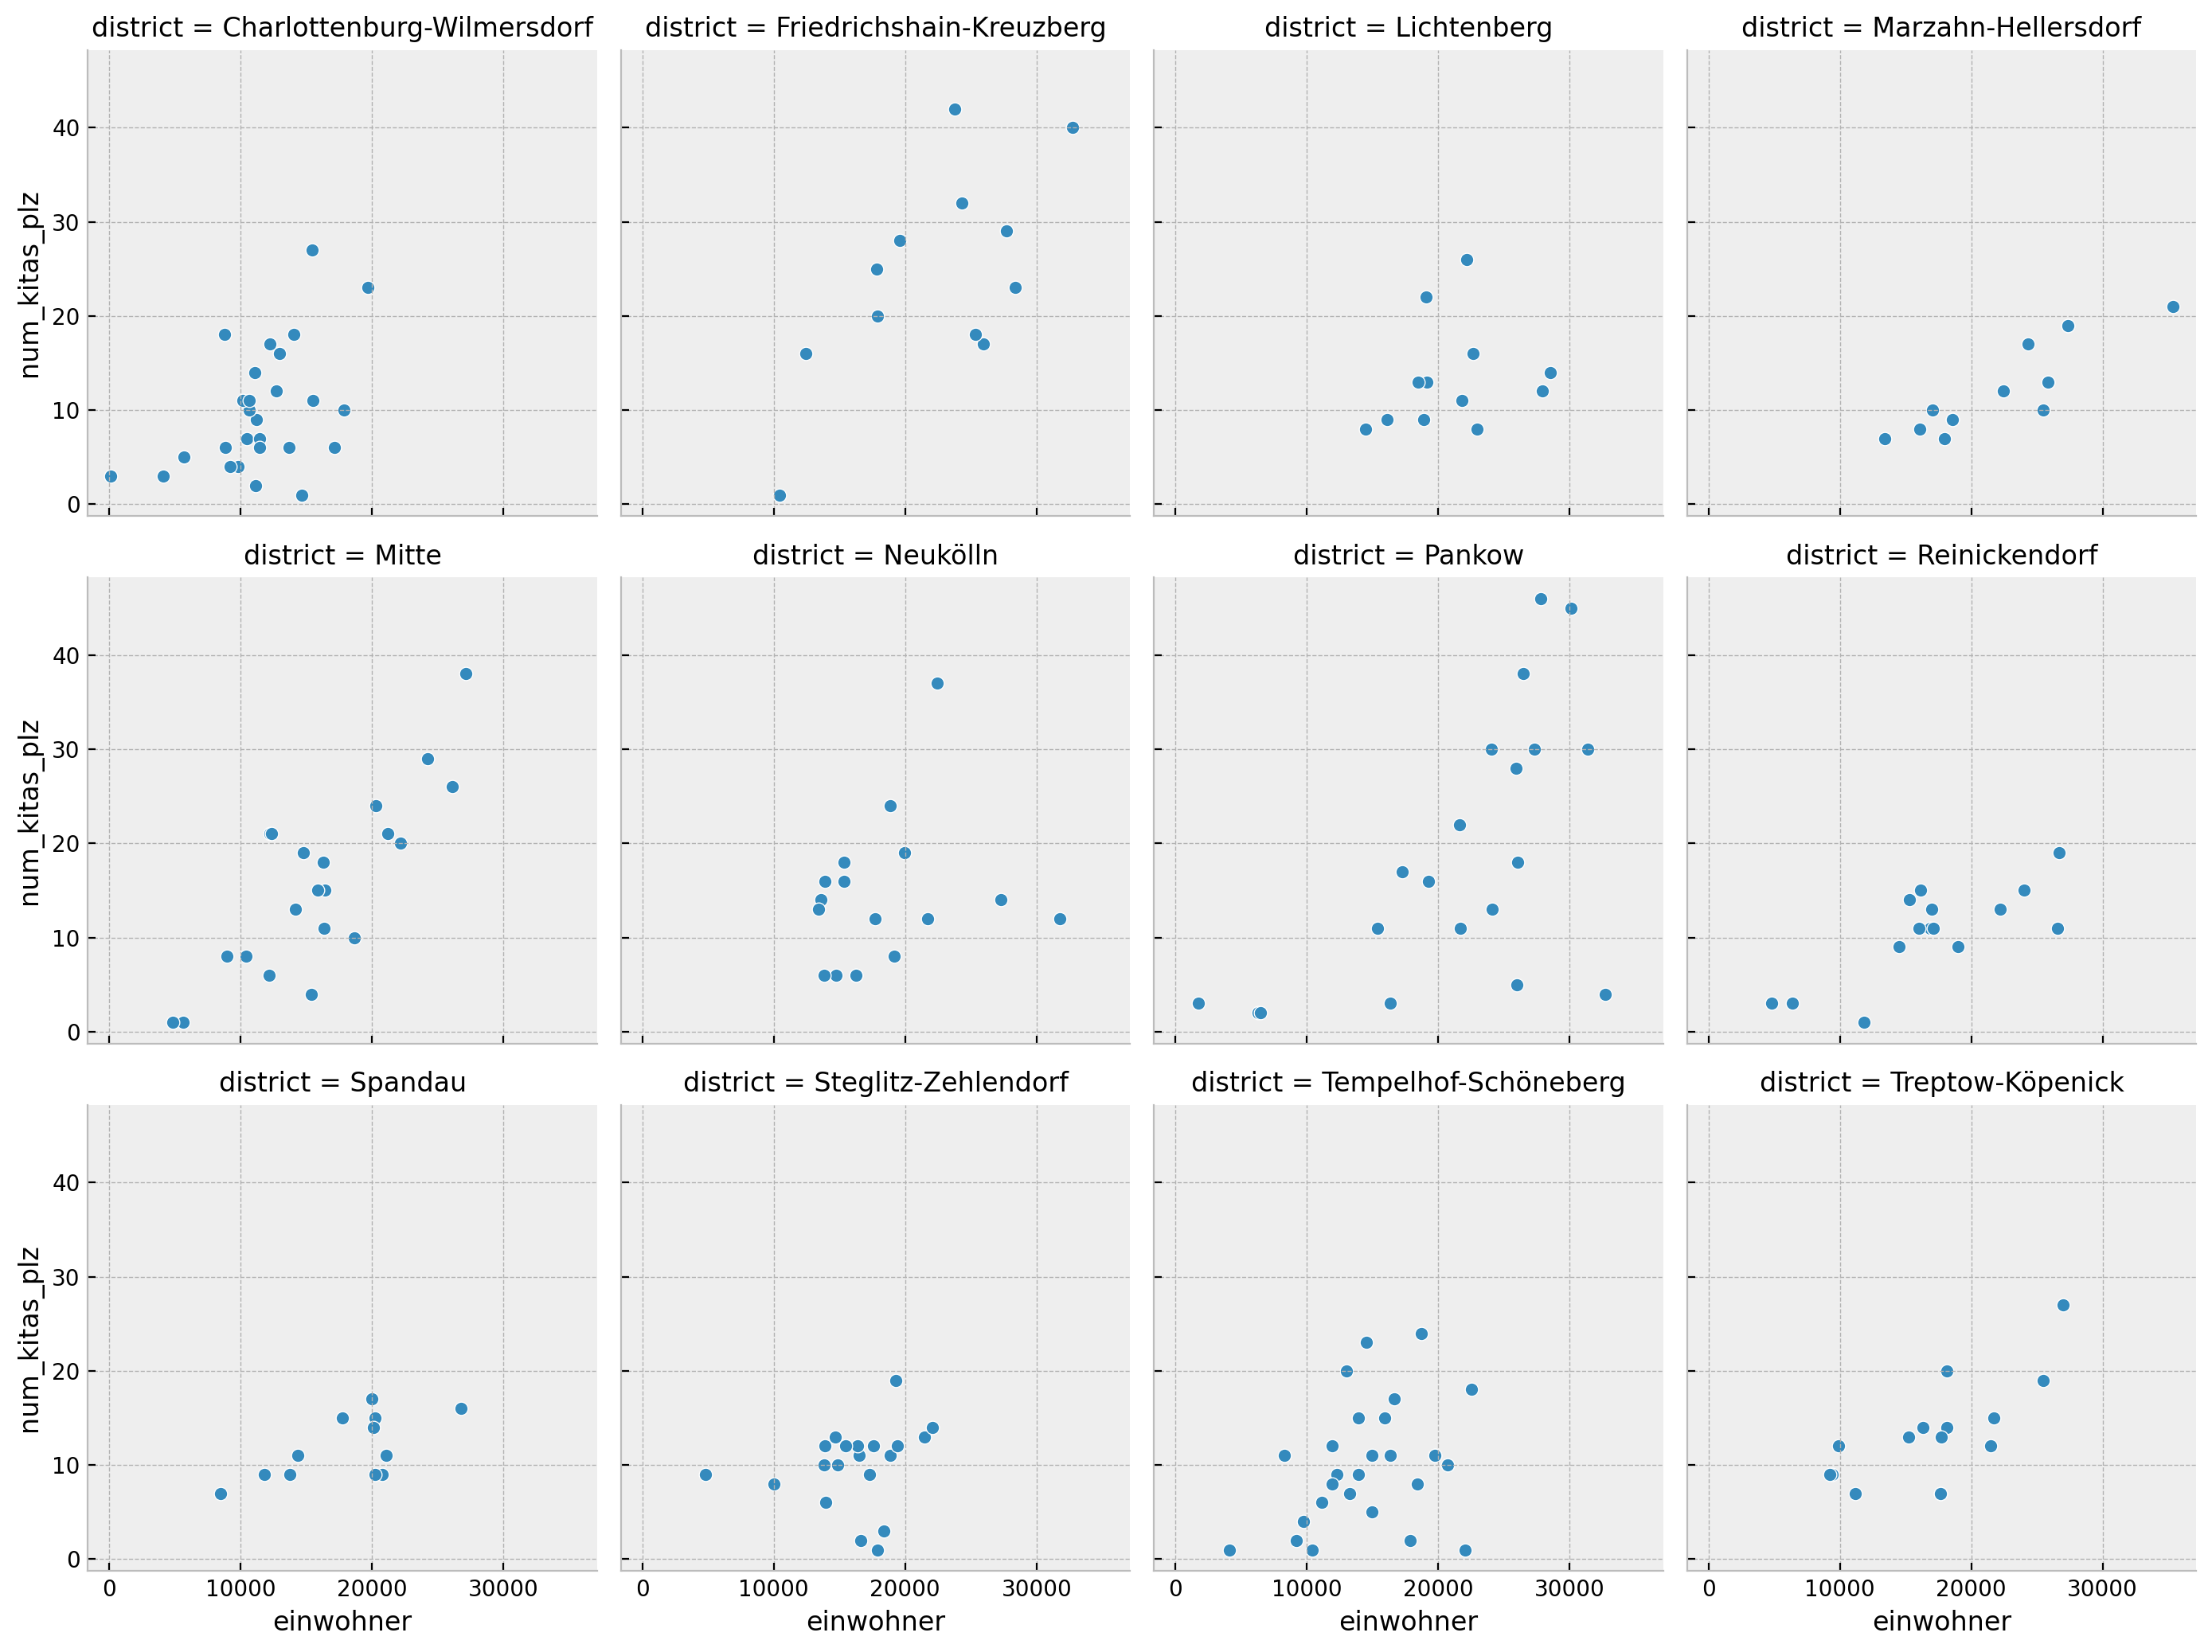

In [3]:
g = sns.relplot(
    data=plz_df,
    x="einwohner",
    y="num_kitas_plz",
    col="district",
    col_wrap=4,
    height=3.5,
    aspect=1,
)


We do see a positive correlation, but the relationship does not seem to be linear.

## Prepare Data

Besides the existing features in the dataset, we extract the area of the geometry defined by the postal code. This will be used as a feature in the model since postal codes with the same number of inhabitants but different area might have different number of Kitas (think about distance to get to the Kitas, for example).

In [4]:
num_kitas_plz = jnp.array(plz_df["num_kitas_plz"].to_numpy())

# https://geopandas.org/en/stable/docs/user_guide/projections.html
plz_df["area"] = plz_df["geometry"].to_crs("EPSG:3395").area
area_normalization = 1e8
area = jnp.array(plz_df["area"].to_numpy() / area_normalization)

einwohner_normalization = 1e4
einwohner = jnp.array(plz_df["einwohner"].to_numpy() / einwohner_normalization)

districts_encoder = LabelEncoder()
districts = districts_encoder.fit_transform(plz_df["district"])

## Model Specification

The model we use is relative straightforward and is a solid baseline. Let's look into the specification:
- We use a [negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) likelihood function as we are modeling count data. We also what to account for overdispersion in the data 9that is why we do not use a Poisson distribution).
- We model the mean of the negative binomial distribution as a linear combination of the features in the dataset. Concretely, we include a an intercept and linear term in the number of inhabitants through a hierarchy defined by the districts. We also include the area of the postal code as a global feature.

\begin{align*}
\text{num\_kitas\_plz} &\sim \text{NegativeBinomial}(\mu, \phi) \\
\phi & =  \frac{1}{\sqrt{\tilde{\phi}}} \\
\mu & = \exp(\alpha_{[i]} + \beta_{[i]}\times{\text{einwohner}} + \gamma \times \text{area}), \quad i = 1, \ldots, 12 \\
\tilde{\phi} & \sim \text{HalfCauchy}(3) \\
\gamma & \sim \text{Normal}(0, 1.5) \\
\alpha_{[i]} & \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha}), \quad i = 1, \ldots, 12 \\
\beta_{[i]} & \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta}), \quad i = 1, \ldots, 12 \\
\mu_{\alpha} & \sim \text{Normal}(0, 1.5) \\
\mu_{\beta} & \sim \text{Normal}(0, 1.5) \\
\sigma_{\alpha} & \sim \text{HalfCauchy}(3) \\
\sigma_{\beta} & \sim \text{HalfCauchy}(3) \\
\end{align*}

Next, we define the model in [`NumPyro`](https://num.pyro.ai/en/latest/index.html#). See my previous post [Simple Hierarchical Model with NumPyro: Cookie Chips Example](https://juanitorduz.github.io/cookies_example_numpyro/) for an introduction to `NumPyro` hierarchical models (please look into the [official documentation](https://num.pyro.ai/en/latest/index.html#introductory-tutorials) as well!). 

**Remarks [Model]:**
- Why shall we have district specific intercepts? Shouldn't no-inhabitants imply no Kitas? Well, not really! There is a spill over effect as some less residential areas can still have Kitas conveniently located so that parents can pick up their kids on their way back from work. This is the reason why we have district specific intercepts. We can of course see the difference across them once we pass the data. Before seeing the data, we still give the benefit of the doubt to the model and let it learn the intercepts.
- We need to wrap the linear combination of features in an exponential "link" function to ensure the mean of the negative binomial distribution is positive. 
- For a negative binomial likelihood, there is a recommended way to set priors on the *concentration* parameter, see [here](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#story-when-the-generic-prior-fails-the-case-of-the-negative-binomial).
- We use `NumPyros` nice re-parametrization capabilities to use a non-centered parametrization so that the model samples better, see the example [Bad posterior geometry and how to deal with it](https://num.pyro.ai/en/latest/tutorials/bad_posterior_geometry.html).

**Remarks [Related Work]:**
- [Corrie Bartelheimer](https://www.samples-of-thoughts.com/) presented a has a nice example where she uses a hierarchical bayesian model to predict housing price in Berlin,  see [here](https://github.com/corriebar/Bayesian-Workflow-with-PyMC)
- There is a nice approach to encode the geo-location proximity using Gaussian Processes. See for example the great post by [Luciano Paz](https://github.com/lucianopaz), [Modeling spatial data with Gaussian processes in PyMC](https://www.pymc-labs.io/blog-posts/spatial-gaussian-process-01/). We do not use this approach here as the number of Kitas does not seem to be continuous in the geo-location space since most of the times these number depends on postal codes specific features (how busy or residential the area is, for example) and the district where the postal code is located. Nevertheless, it would be interesting to explore this approach in the future (maybe a one-dimensional Gaussian Process in the postal code names itself?).

In [5]:
def model(
    area: ArrayImpl,
    einwohner: ArrayImpl,
    districts: ArrayImpl,
    num_kitas_plz: ArrayImpl | None = None,
) -> None:
    """Hierarchical model for the number of kitas per plz as a function of the number
    of inhabitants (eihnwohner) and the district.

    Parameters
    ----------
    area : ArrayImpl
        Area of the plz.
    einwohner : ArrayImpl
        Number of inhabitants per plz.
    districts : ArrayImpl
        Districts of the plz.
    num_kitas_plz : ArrayImpl | None, optional
        Number of Kitas per plz, by default None
    """
    # Priors
    intercept_loc = numpyro.sample(
        name="intercept_loc", fn=dist.Normal(loc=0, scale=1.5)
    )
    intercept_scale = numpyro.sample(
        name="intercept_scale", fn=dist.HalfCauchy(scale=3)
    )
    slope_einwohner_loc = numpyro.sample(
        name="slope_einwohner_loc", fn=dist.Normal(loc=0, scale=1.5)
    )
    slope_einwohner_scale = numpyro.sample(
        name="slope_einwohner_scale", fn=dist.HalfCauchy(scale=3)
    )
    beta_area = numpyro.sample(name="beta_area", fn=dist.Normal(loc=0, scale=1.5))

    # We set the prior for the concentration parameter of the Negative Binomial
    # distribution on a transformed variable as suggested in
    # https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#story-when-the-generic-prior-fails-the-case-of-the-negative-binomial
    concentration_tilde = numpyro.sample(
        name="concentration_tilde", fn=dist.HalfCauchy(scale=3)
    )
    concentration = numpyro.deterministic(
        name="concentration", value=1 / jnp.square(concentration_tilde)
    )

    # Variables parametrization
    n_districts = np.unique(districts).size

    with numpyro.plate(name="districts", size=n_districts):
        intercept_district = numpyro.sample(
            name="intercept_district",
            fn=dist.Normal(loc=intercept_loc, scale=intercept_scale),
        )
        slope_einwohner = numpyro.sample(
            name="slope_einwohner",
            fn=dist.Normal(loc=slope_einwohner_loc, scale=slope_einwohner_scale),
        )

    log_mu = numpyro.deterministic(
        name="log_mu",
        value=intercept_district[districts]
        + slope_einwohner[districts] * einwohner
        + beta_area * area,
    )
    # We apply an exponential (link) function to make sure that mu is positive
    mu = numpyro.deterministic(name="mu", value=jnp.exp(log_mu))

    n_obs: int = einwohner.size

    # Likelihood
    with numpyro.plate(name="data", size=n_obs):
        numpyro.sample(
            name="obs",
            fn=dist.NegativeBinomial2(
                mean=mu,
                concentration=concentration,
            ),
            obs=num_kitas_plz,
        )

We can take a look into the model diagram to get a more visual representation of the model.

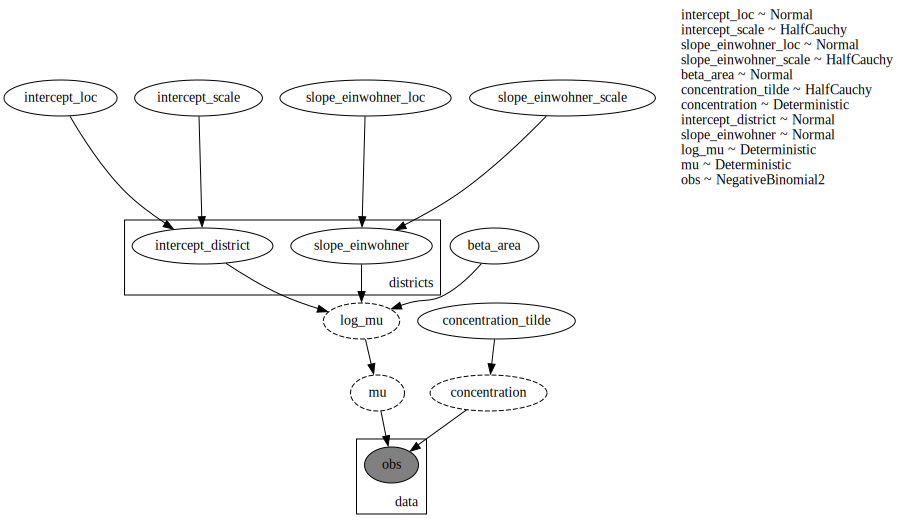

In [6]:
numpyro.render_model(
    model=model,
    model_args=(area, einwohner, districts, num_kitas_plz),
    render_distributions=True,
    render_params=True,
)

Now, we run the re-parametrization procedure. Note how easy is to do it in `NumPyro`! Most of the times is safer than doing it by hand. Still, it is important to understand the logic behind it. See the seminal post [Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) by [Thomas Wiecki](https://www.pymc-labs.io/team/thomas-wiecki/).

In [7]:
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {
    "intercept_district": LocScaleReparam(centered=0),
    "slope_einwohner": LocScaleReparam(centered=0),
}

reparam_model = reparam(fn=model, config=reparam_config)

Let's see the diagram of the re-parametrized model.

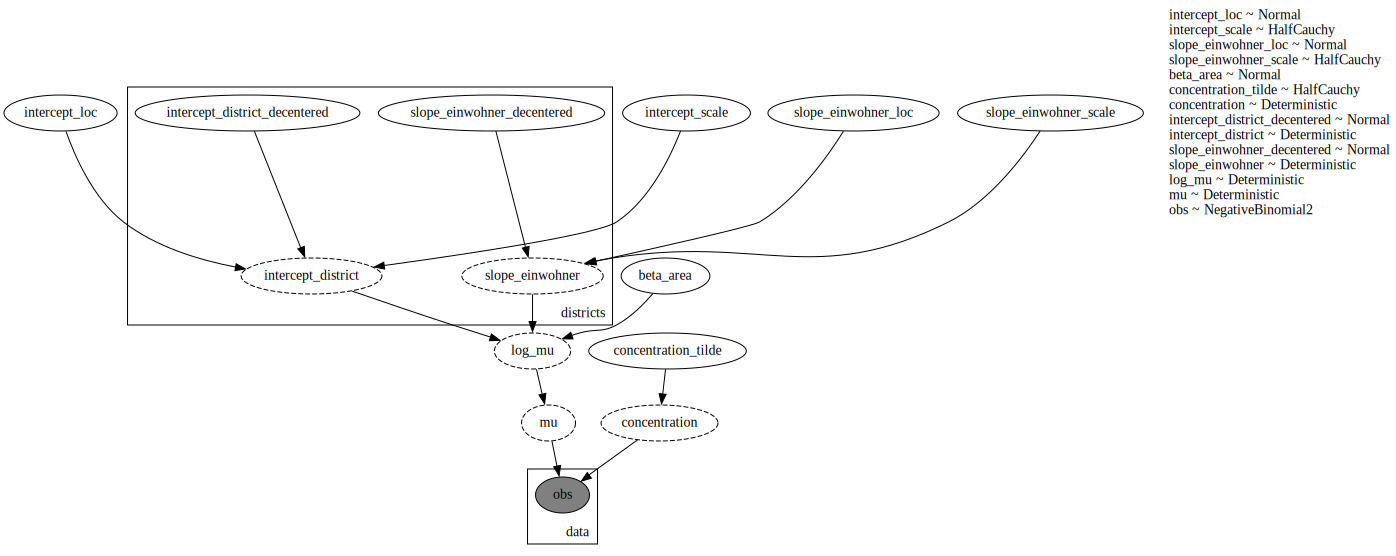

In [8]:
numpyro.render_model(
    model=reparam_model,
    model_args=(area, einwohner, districts, num_kitas_plz),
    render_distributions=True,
    render_params=True,
)

## Model Fitting

Now we run the [NUTS sampler](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo#No_U-Turn_Sampler)!

In [9]:
# set sampler
nuts_kernel = NUTS(model=reparam_model, target_accept_prob=0.95)
mcmc = MCMC(sampler=nuts_kernel, num_samples=6_000, num_warmup=2_000, num_chains=4)
# run sampler
rng_key, rng_subkey = random.split(key=rng_key)
mcmc.run(rng_subkey, area, einwohner, districts, num_kitas_plz)
# get posterior samples
posterior_samples = mcmc.get_samples()
# get posterior predictive samples
posterior_predictive = Predictive(
    model=reparam_model, posterior_samples=posterior_samples
)
rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey, area, einwohner, districts
)
# convert to arviz inference data object
idata = az.from_numpyro(
    posterior=mcmc,
    posterior_predictive=posterior_predictive_samples,
    coords={"districts": districts_encoder.classes_, "plz": plz_df["plz"].to_numpy()},
    dims={
        "intercept_district": ["districts"],
        "slope_einwohner": ["districts"],
        "intercept_district_decentered": ["districts"],
        "slope_einwohner_decentered": ["districts"],
        "mu": ["plz"],
        "obs": ["plz"],
    },
)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

The model samples in less than a minute!

## Diagnostics

We now inspect the diagnostics of the model.

In [10]:
idata["sample_stats"]["diverging"].sum().item()


0

No divergences 🚀 ! We now look into the summary of the model parameters.

In [11]:
az.summary(
    data=idata,
    var_names=[
        "~mu",
        "~log_mu",
        "~intercept_district_decentered",
        "~slope_einwohner_decentered",
    ],
)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_area,-0.129,0.269,-0.642,0.375,0.001,0.002,33491.0,17233.0,1.0
concentration,6.118,0.967,4.459,8.015,0.005,0.004,33436.0,18081.0,1.0
concentration_tilde,0.408,0.032,0.348,0.468,0.000,0.000,33436.0,18081.0,1.0
intercept_district[Charlottenburg-Wilmersdorf],1.460,0.133,1.209,1.709,0.001,0.001,20419.0,19216.0,1.0
intercept_district[Friedrichshain-Kreuzberg],1.504,0.166,1.192,1.817,0.001,0.001,15002.0,17306.0,1.0
intercept_district[Lichtenberg],1.411,0.159,1.114,1.712,0.001,0.001,16552.0,17938.0,1.0
intercept_district[Marzahn-Hellersdorf],1.362,0.179,0.999,1.670,0.002,0.001,11985.0,15803.0,1.0
intercept_district[Mitte],1.483,0.149,1.210,1.771,0.001,0.001,16131.0,18535.0,1.0
intercept_district[Neukölln],1.460,0.149,1.174,1.736,0.001,0.001,20154.0,19153.0,1.0
intercept_district[Pankow],1.421,0.156,1.131,1.720,0.001,0.001,18569.0,19533.0,1.0


Everything looks good! We can also visualize the posterior distributions of the parameters.

Text(0.5, 0.98, 'Model Trace')

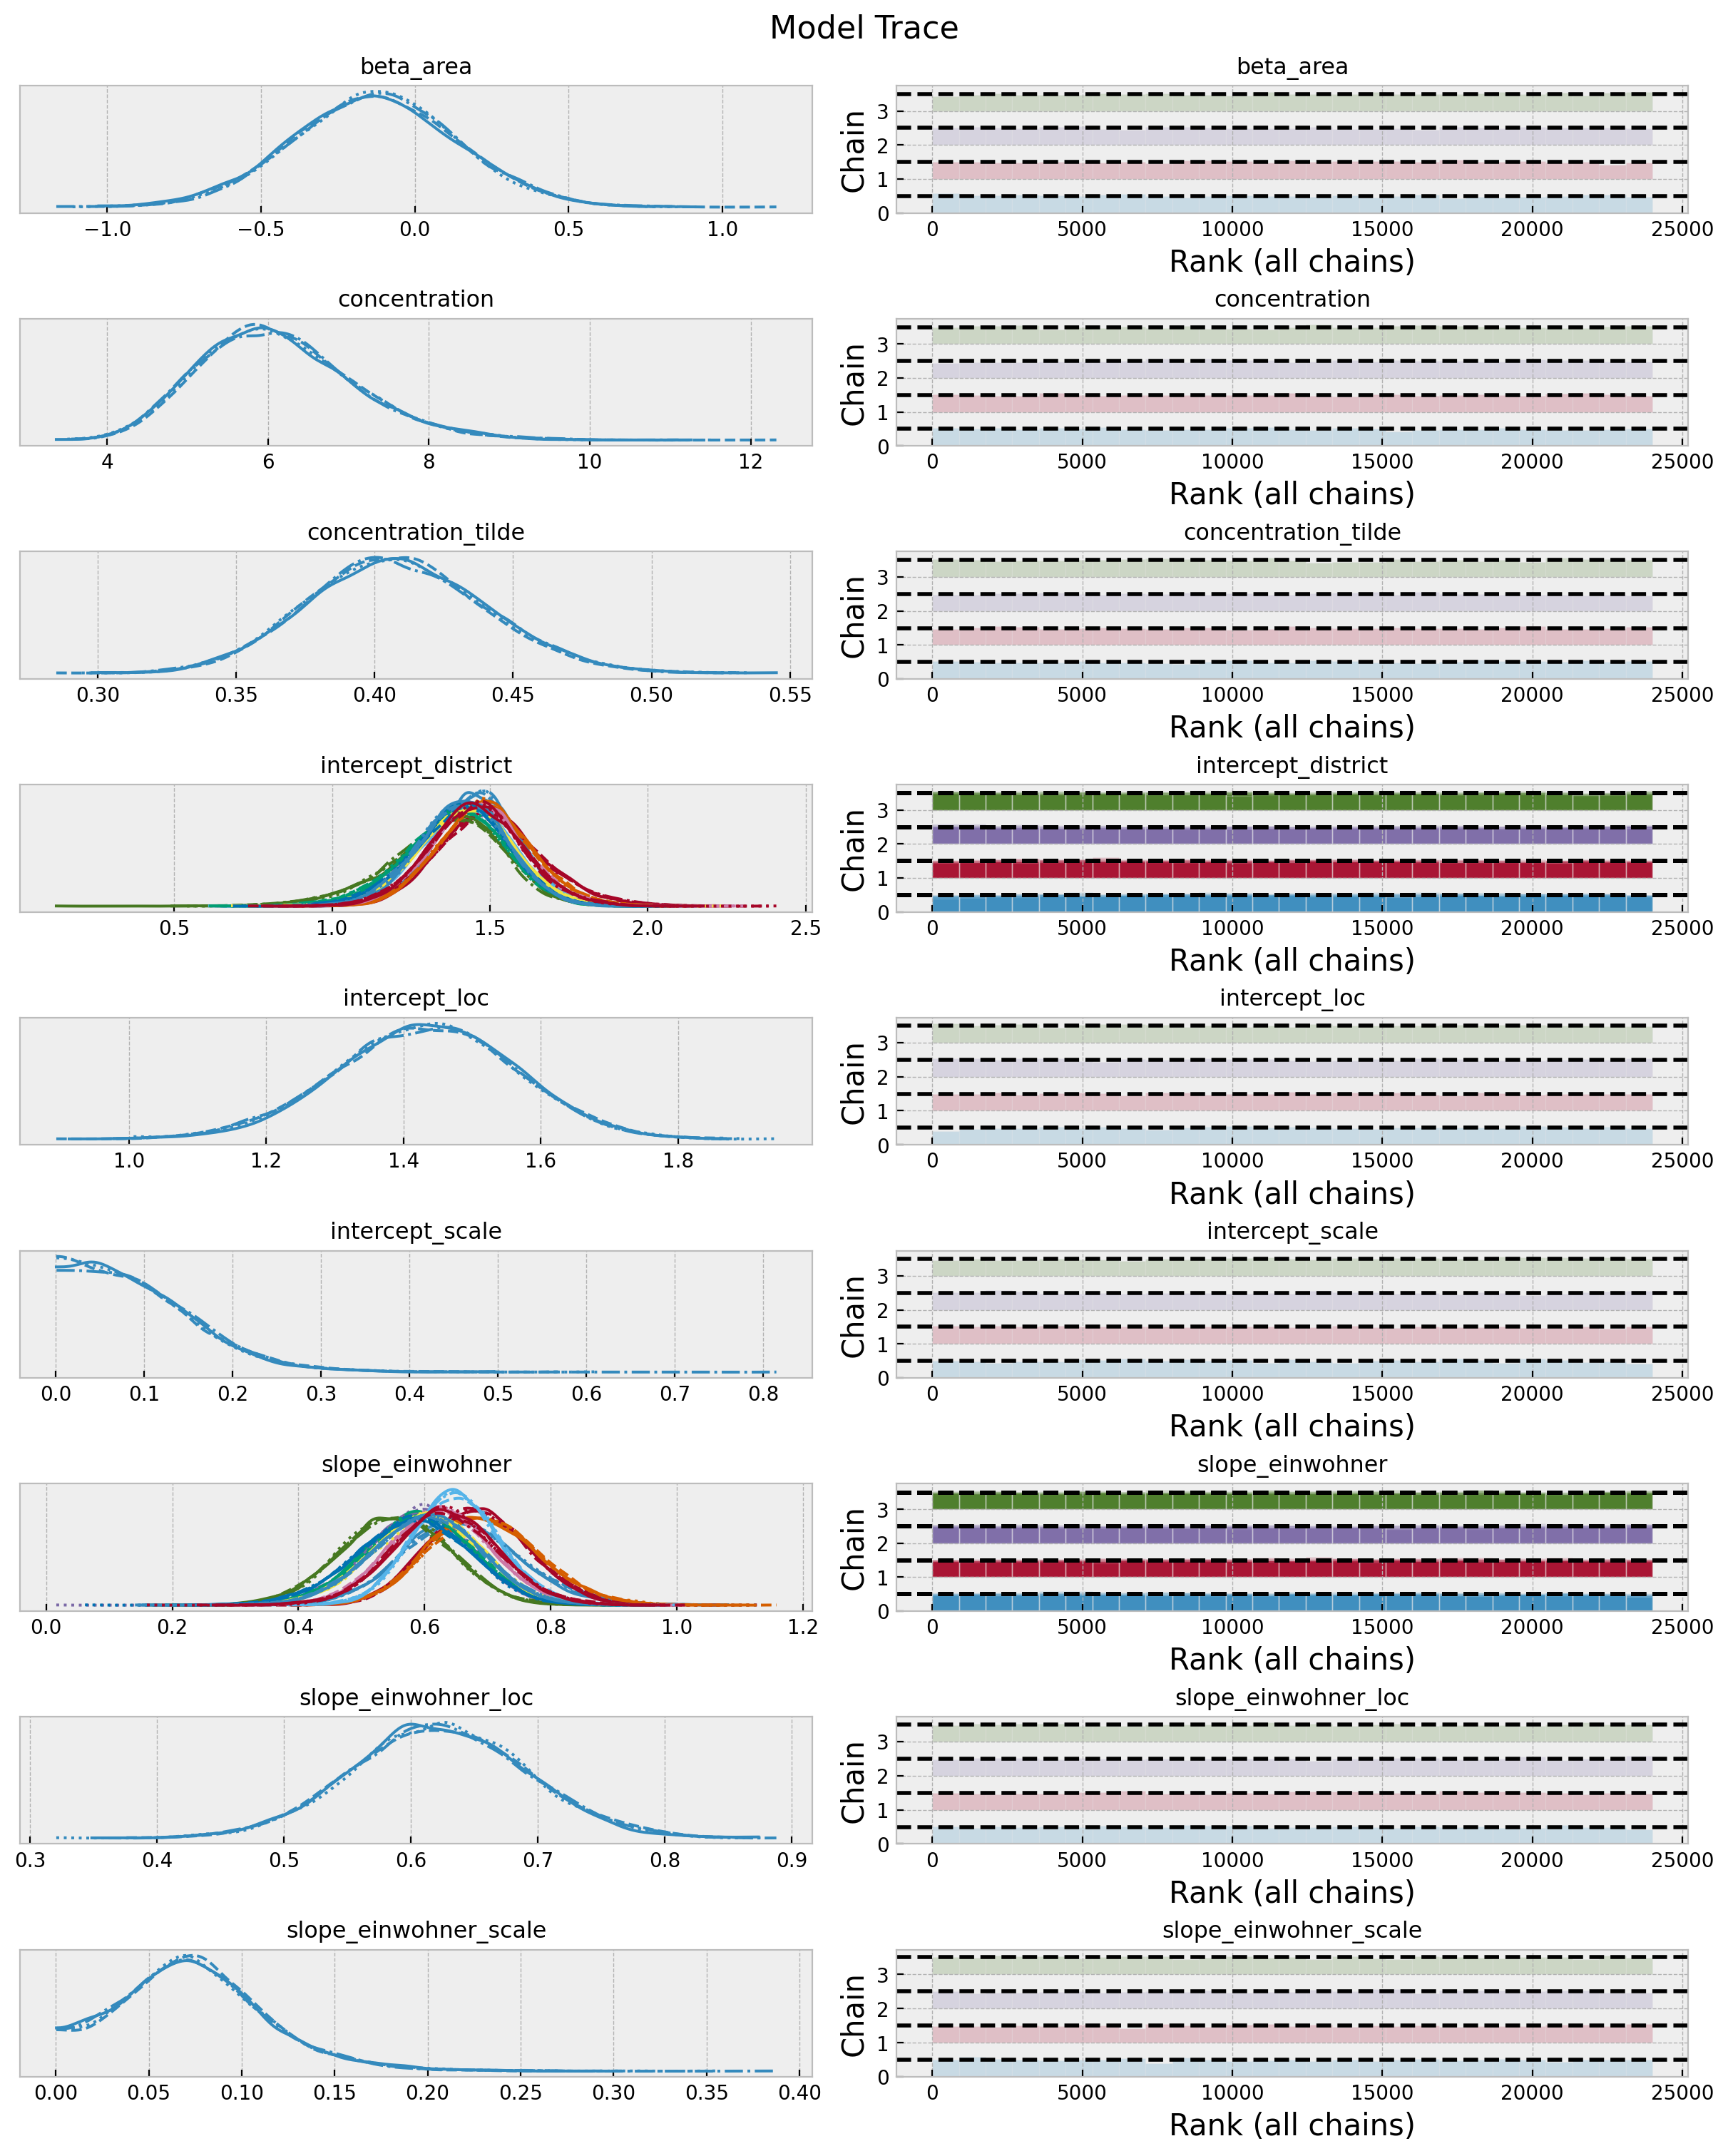

In [12]:
axes = az.plot_trace(
    data=idata,
    var_names=[
        "~mu",
        "~log_mu",
        "~intercept_district_decentered",
        "~slope_einwohner_decentered",
    ],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16)


All the chains look good indeed! 

**Remarks:**
- We see a higher difference across districts in the inhabitants slope than in the intercept. This is telling us that for very small postal codes the baseline is very similar across postal codes, but as the number of inhabitants increases, the number of Kitas increases at a higher rate in some districts than in others.
- The contribution of the area feature is almost negligible.

## Posterior Predictive Checks

Let's look into the posterior predictive distribution.

[Text(0.5, 1.0, 'Posterior Predictive Check')]

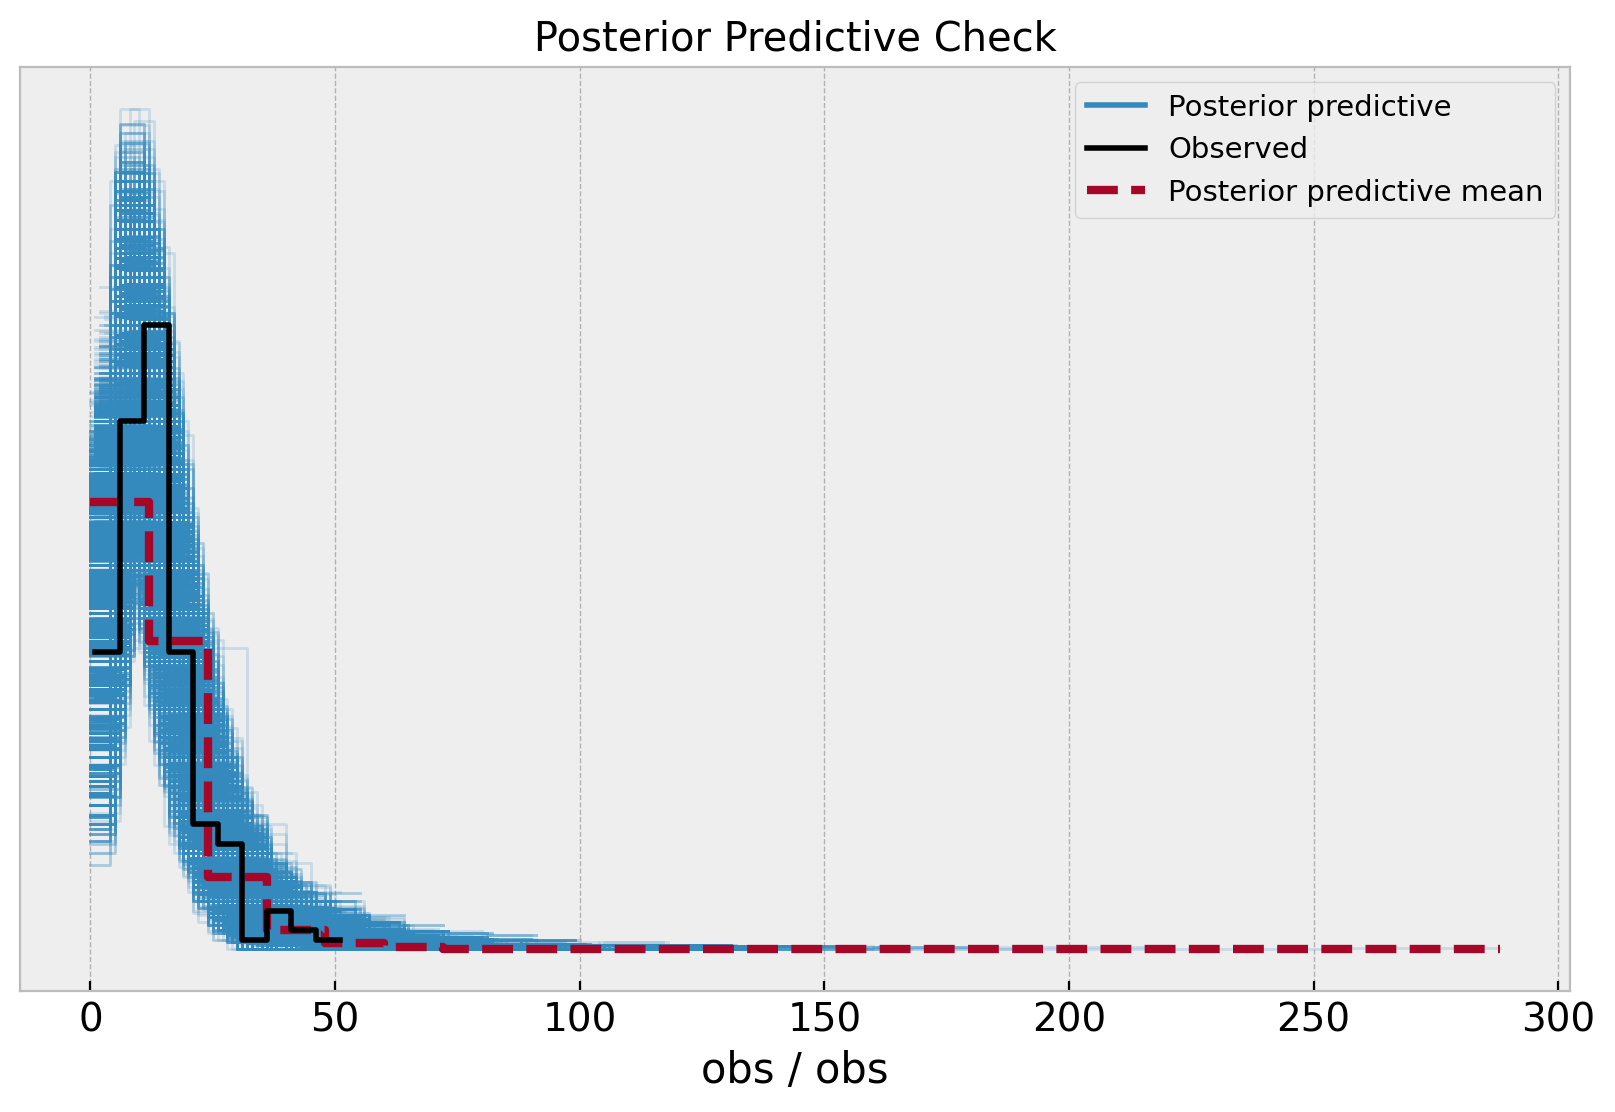

In [13]:
ax = az.plot_ppc(
    data=idata,
    observed_rug=True,
)
ax.set(
    title="Posterior Predictive Check",
)

It seems the model is over estimating the postal codes with few Kitas. 

Let's not visualize the posterior predictive distribution of the number of Kitas per postal code as a function of the number of inhabitants.

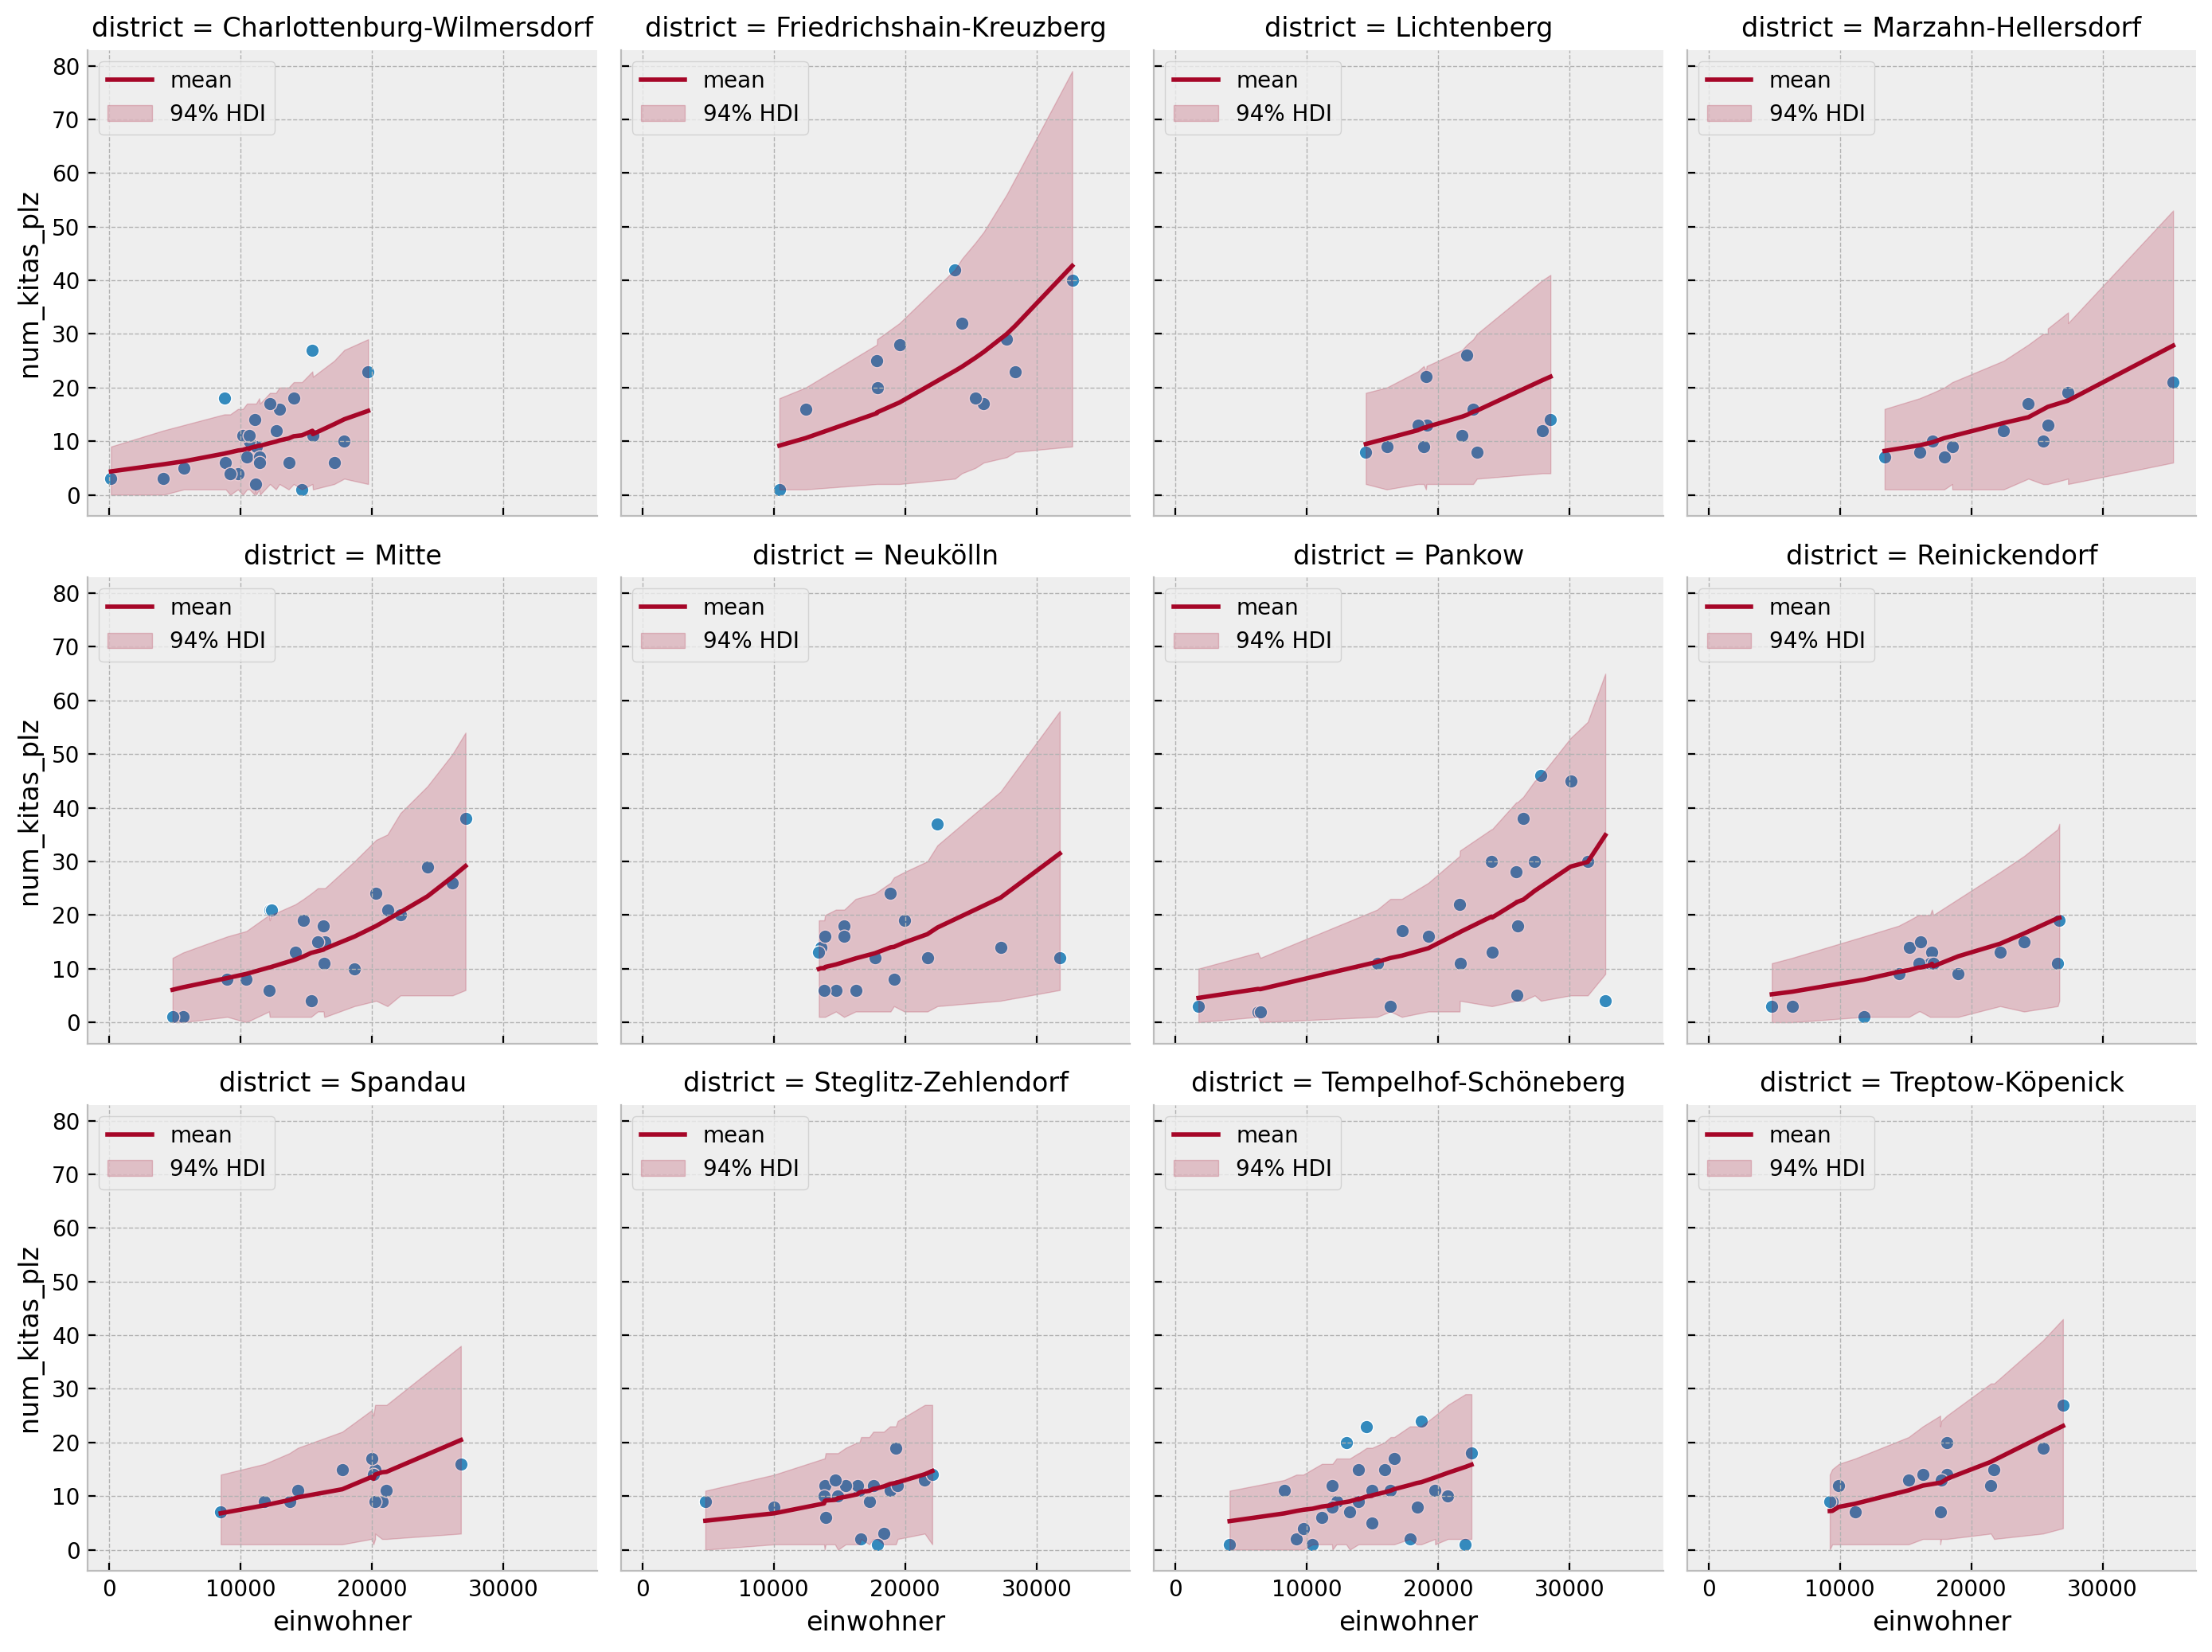

In [14]:
plz_df["num_kitas_plz_pred_mean"] = idata["posterior_predictive"]["obs"].mean(
    dim=["chain", "draw"]
)

posterior_predictive_hdi_94 = az.hdi(
    ary=idata, group="posterior_predictive", hdi_prob=0.94
)["obs"]

plz_df["num_kitas_plz_pred_hdi_lower_94"] = posterior_predictive_hdi_94.sel(hdi="lower")
plz_df["num_kitas_plz_pred_hdi_higher_94"] = posterior_predictive_hdi_94.sel(
    hdi="higher"
)


g = sns.relplot(
    data=plz_df,
    x="einwohner",
    y="num_kitas_plz",
    color="C0",
    col="district",
    col_wrap=4,
    height=3.5,
    aspect=1,
)

for district, ax in g.axes_dict.items():
    mask = "district == @district"
    district_df = plz_df.query(mask).sort_values(by="einwohner")

    sns.lineplot(
        data=district_df,
        x="einwohner",
        y="num_kitas_plz_pred_mean",
        color="C1",
        label="mean",
        ax=ax,
    )

    ax.fill_between(
        x=district_df["einwohner"],
        y1=district_df["num_kitas_plz_pred_hdi_lower_94"],
        y2=district_df["num_kitas_plz_pred_hdi_higher_94"],
        color="C1",
        alpha=0.2,
        label="94% HDI",
    )
    ax.legend(loc="upper left")


We indeed see how the model is capturing some reasonable district-level trend in the number of Kitas per postal code as a function of the number of inhabitants. The *growth strength* is encoded in the `slope_einwohner` parameter.

Text(0.5, 1.0, 'Slope Einwohner Posterior')

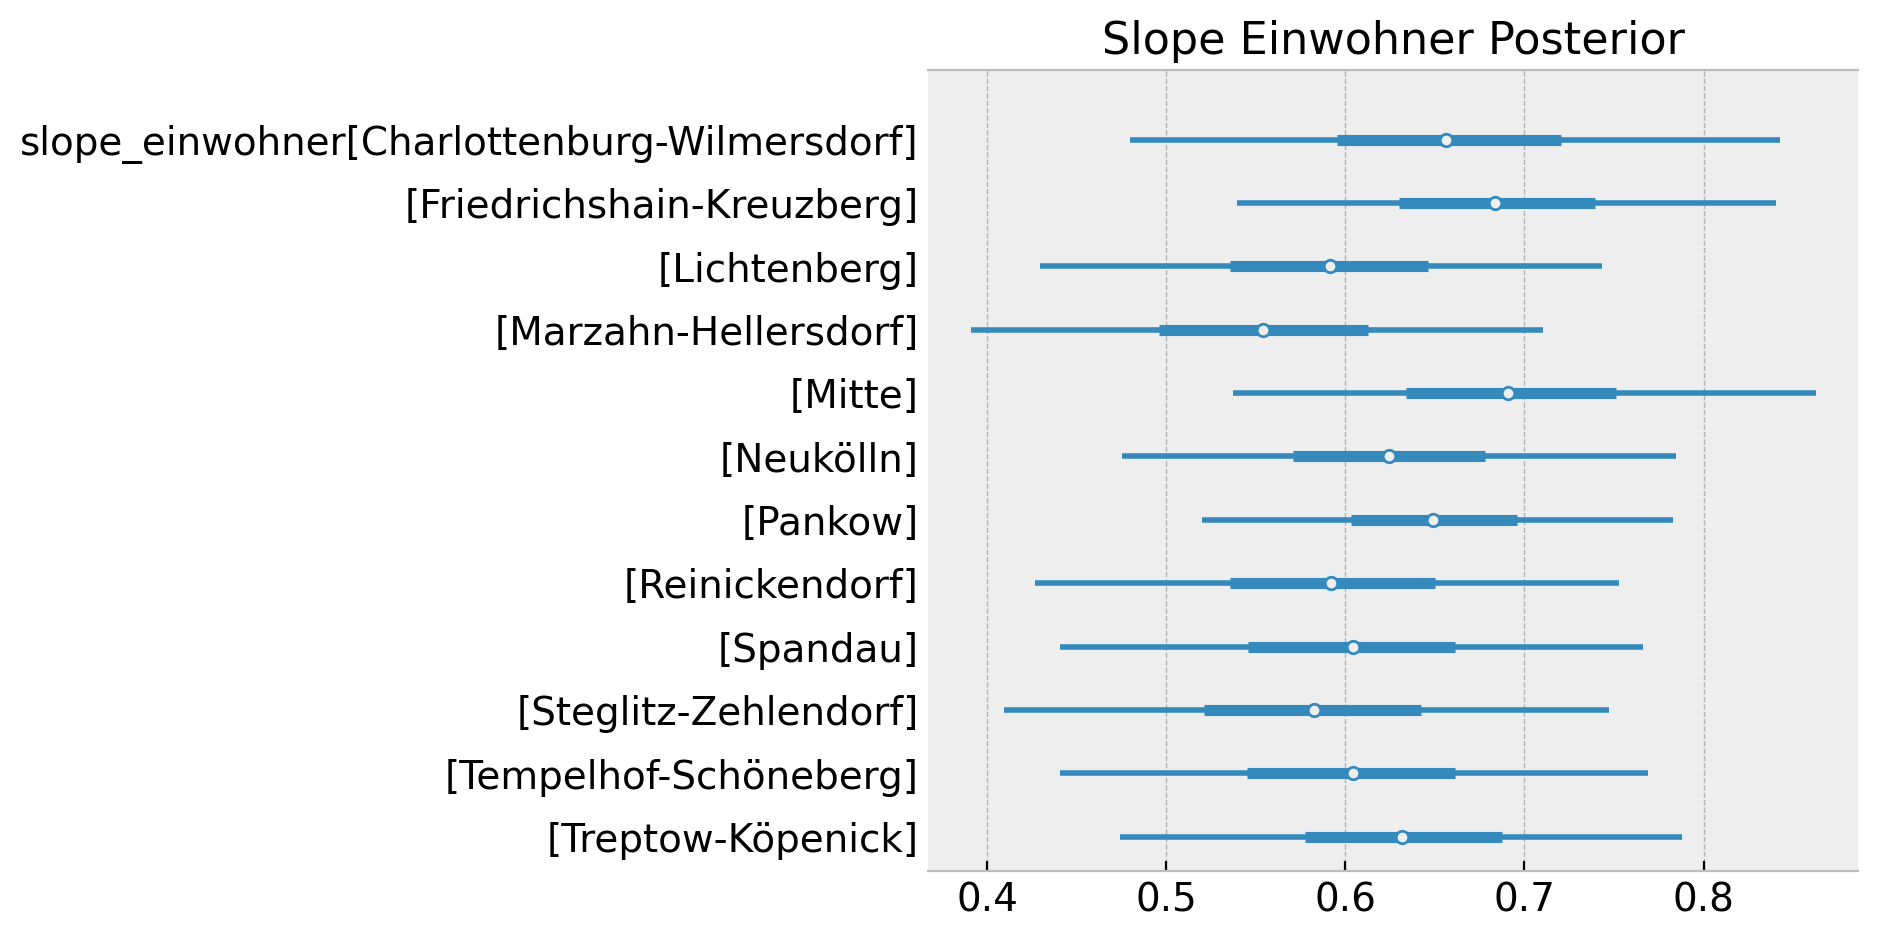

In [15]:
ax, *_ = az.plot_forest(data=idata, var_names=["slope_einwohner"], combined=True)
ax.set_title("Slope Einwohner Posterior", fontsize=16)


The district with stronger growth (as a function of inhabitants) is Mitte followed very closely by Friedrichshain-Kreuzberg. The district with the lowest growth is Marzahn-Hellersdorf. We can verify this is consistent with the results above if we plot the posterior predictive mean of all districts in the same plot.

[Text(0.5, 1.0, 'Posterior Predictive Mean - Slope Einwohner'),
 Text(0.5, 0, 'einwohner'),
 Text(0, 0.5, 'number of kitas')]

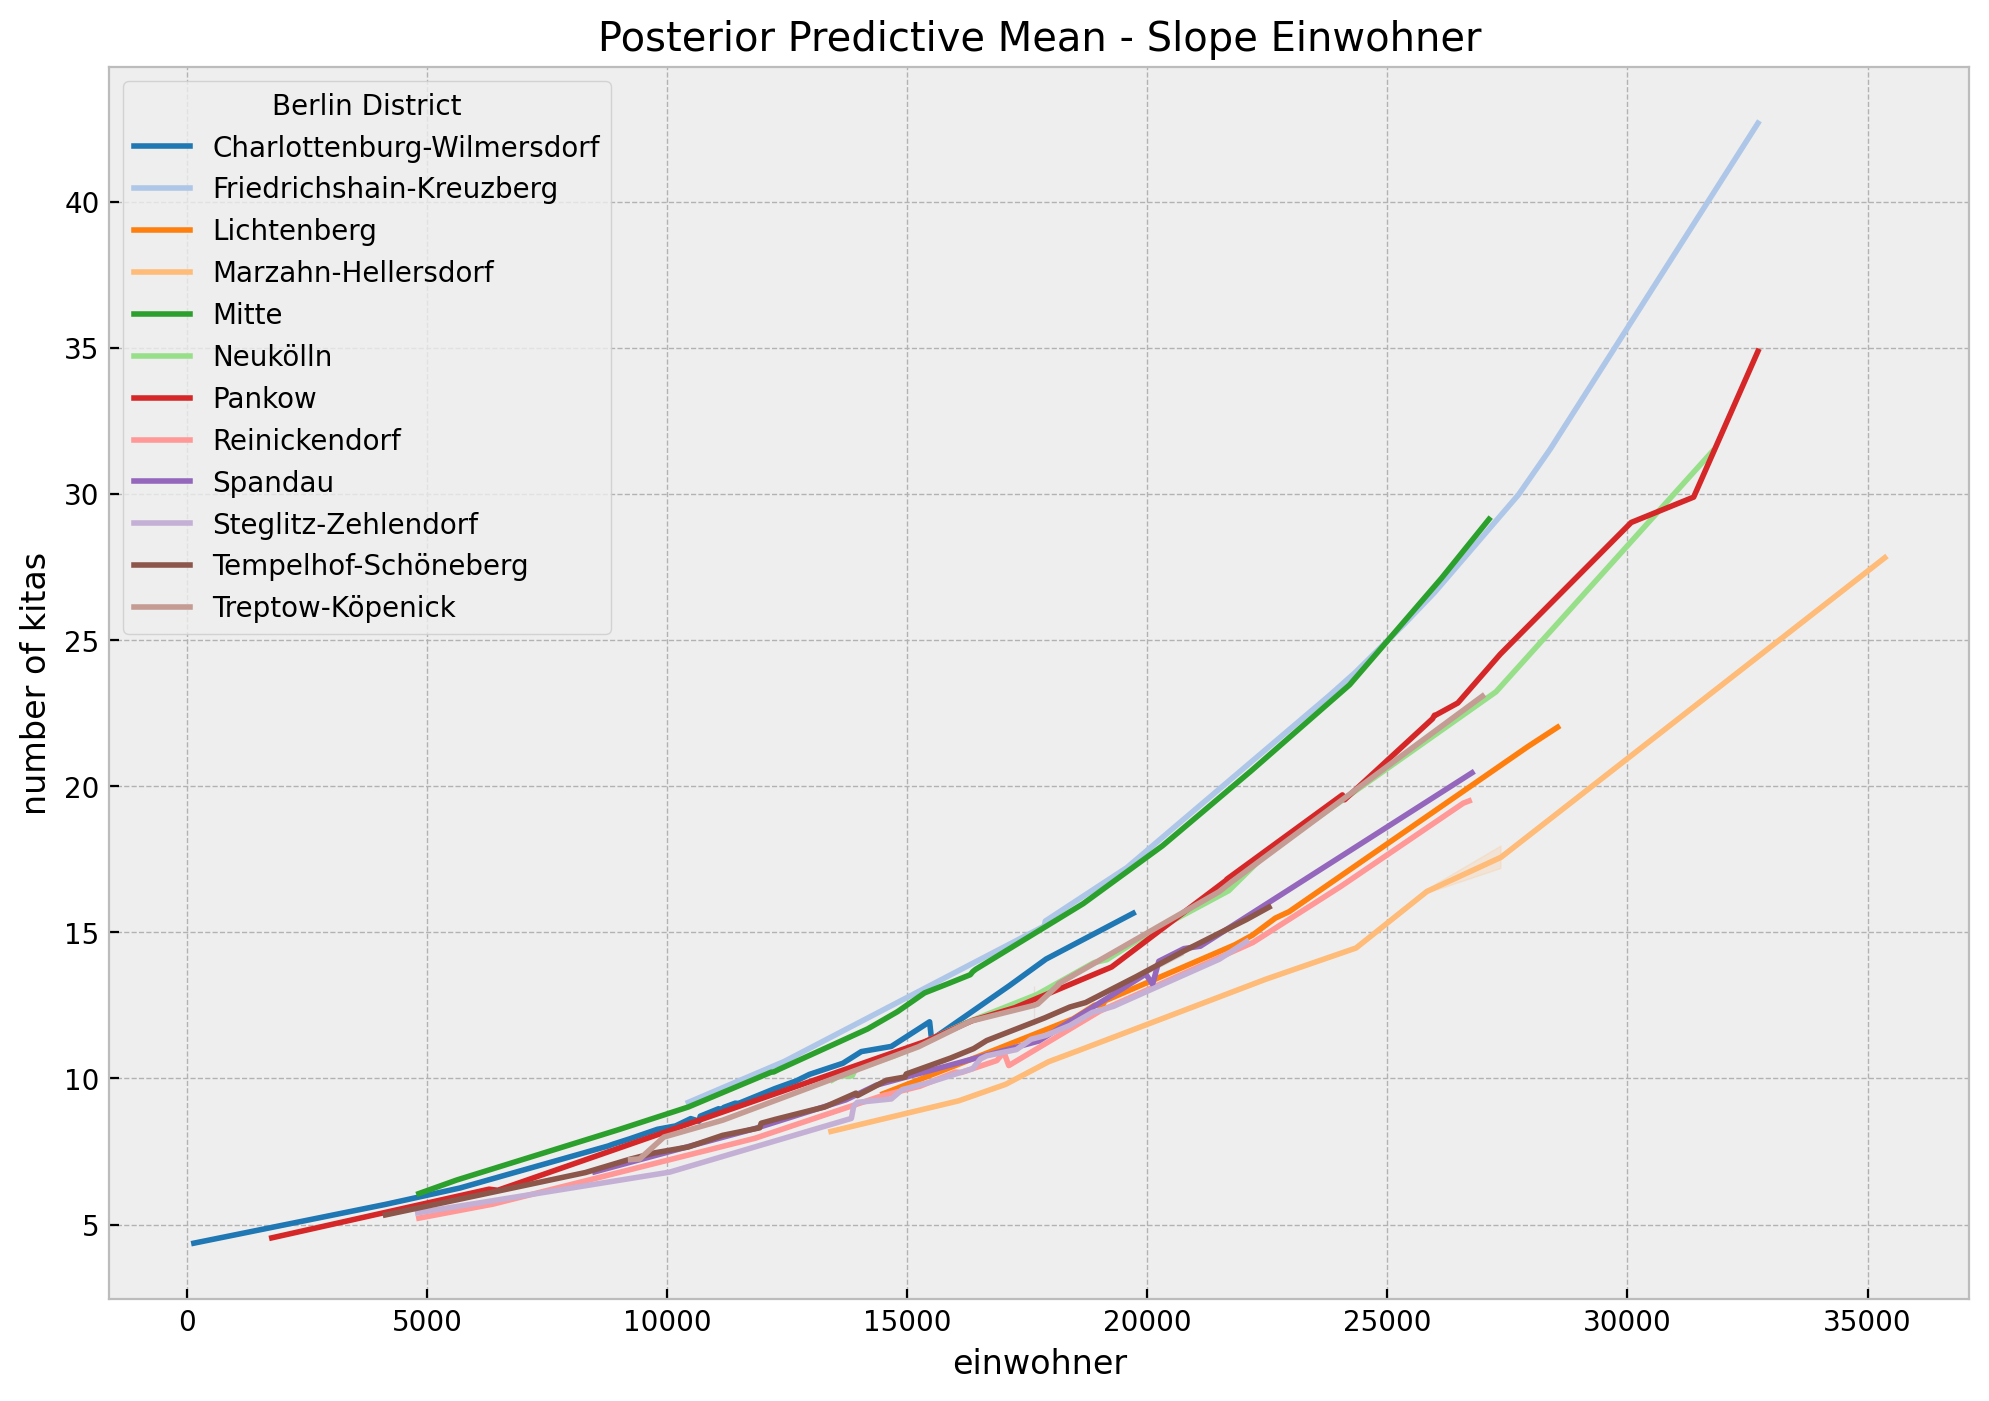

In [16]:
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i, _ in enumerate(districts_encoder.classes_)]

fig, ax = plt.subplots(figsize=(12, 8))

for i, district in enumerate(districts_encoder.classes_):
    district_df = plz_df.query("district == @district").sort_values(by="einwohner")

    sns.lineplot(
        data=district_df,
        x="einwohner",
        y="num_kitas_plz_pred_mean",
        color=colors[i],
        label=district,
        ax=ax,
    )

ax.legend(title="Berlin District", loc="upper left")
ax.set(
    title="Posterior Predictive Mean - Slope Einwohner",
    xlabel="einwohner",
    ylabel="number of kitas",
)

In this plot we can also confirm that the intercept variation across postal codes is not very large. This mean that all of them have a very similar baseline. We can start seeing bigger differences once the postal code area has more than 15,000 inhabitants.